# Background
Getting the path, loading the train/valid and creating datablock

~Create a python enviroment version 3.11.8 is possible then install everything in requirements.txt~

In [45]:
# Set the path to where you have the dataset ex. "C:\Users\James\Desktop\bone freacture 451 project\bone_fracture_dataset_splitted"
path = r'C:\Users\James\Desktop\bone freacture 451 project\bone_fracture_dataset_combined'
path

'C:\\Users\\James\\Desktop\\bone freacture 451 project\\bone_fracture_dataset_combined'

In [46]:
# importing the data.yaml (should be in same folder where dataset is)

import yaml

with open(path+'/data.yaml', 'r') as f:
    data_structure = yaml.safe_load(f)
    print(data_structure)

{'train': '../train/images', 'val': '../valid/images', 'test': '../test/images', 'nc': 7, 'names': ['elbow positive', 'fingers positive', 'forearm fracture', 'humerus fracture', 'humerus', 'shoulder fracture', 'wrist positive'], 'roboflow': {'workspace': 'veda', 'project': 'bone-fracture-detection-daoon', 'version': 4, 'license': 'CC BY 4.0', 'url': 'https://universe.roboflow.com/veda/bone-fracture-detection-daoon/dataset/4'}}


In [48]:
from fastai.vision.all import *
import yaml
import pandas as pd
import warnings

data_dir = Path(path)
all_image_path = data_dir/'trainValidTest/images'
all_label_path = data_dir/'trainValidTest/labels'

class_names = data_structure['names']  # Load class names from YAML

def get_label(file_path):
    label_file_name = '.'.join(str(file_path.name).split('.')[:-1]) + '.txt'
    label_file_path = all_label_path/label_file_name
    with open(label_file_path, 'r') as label_file:
        label_values = label_file.read().split(' ')
        label = label_values[0]
        return class_names[int(label)] if label else 'N'

def train_valid_test_indices(items, test_pct, seed=None):
    """Generate indices for train-validation and test datasets."""
    np.random.seed(seed)
    total_len = len(items)
    shuffled_indices = np.random.permutation(total_len)
    
    # Calculate number of items in the test set
    test_size = int(test_pct * total_len)
    test_idxs = shuffled_indices[:test_size]
    trainvalid_idxs = shuffled_indices[test_size:]
    
    return trainvalid_idxs, test_idxs

# Obtain image files
image_files = get_image_files(all_image_path)

# Split indices for train-validation and test sets
trainvalid_idxs, test_idxs = train_valid_test_indices(image_files, test_pct=0.1, seed=42)

# Split image files according to the indices
trainvalid_image_files, test_image_files = image_files[trainvalid_idxs], image_files[test_idxs]

# Setting up the FastAI DataBlock with a simple RandomSplitter for train and validation
bone_fractures = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda x: trainvalid_image_files,  # Provide train-validation image files
    splitter=RandomSplitter(valid_pct=0.2, seed=42),  # Splits trainvalid into train and valid
    get_y=get_label,
    item_tfms=Resize(256),
    batch_tfms=aug_transforms(size=256, min_scale=0.75)
)

# Load the data for train and validation
trainValid_Dls = bone_fractures.dataloaders(source=trainvalid_image_files, bs=64)

print(class_names)


['elbow positive', 'fingers positive', 'forearm fracture', 'humerus fracture', 'humerus', 'shoulder fracture', 'wrist positive']


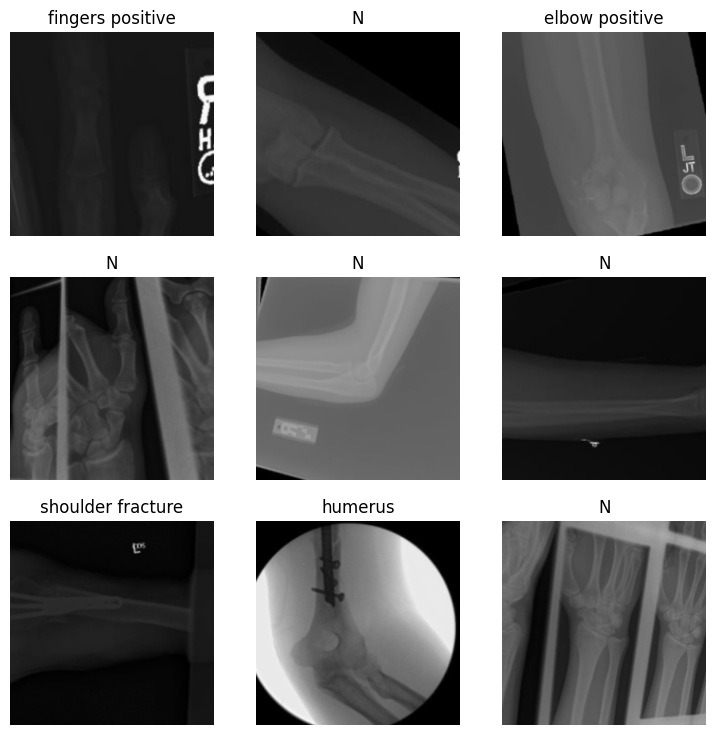

In [49]:
# Show an example
trainValid_Dls.show_batch()

# Counting the classes

In [50]:
from collections import Counter
import os

# Initialize a counter for all labels, including 'N'
label_counter = Counter()
labels = []

# Function to update the counter based on the label of each file
def update_label_counter(file_path):
    label_file_name = '.'.join(str(file_path.name).split('.')[:-1]) + '.txt'
    label_file_path = all_label_path / label_file_name
    label = 'N'  # Default to 'N'
    
    with open(label_file_path, 'r') as label_file:
        label_values = label_file.read().strip().split(' ')
        if label_values[0].isdigit():
            label_index = int(label_values[0])
            if label_index < len(class_names):
                label = class_names[label_index]
                
    # Update the counter
    label_counter[label] += 1
    labels.append(label)

# Iterate over image files in the trainValidTest directory
image_files = get_image_files(all_image_path)
for image_file in image_files:
    update_label_counter(image_file)

# Display the count for each label, including 'N'
print(f"Label counts: {label_counter}")

Label counts: Counter({'N': 2088, 'fingers positive': 496, 'shoulder fracture': 349, 'elbow positive': 347, 'humerus': 344, 'forearm fracture': 333, 'wrist positive': 191})


In [12]:
#print(labels)

['elbow positive', 'elbow positive', 'elbow positive', 'elbow positive', 'elbow positive', 'elbow positive', 'elbow positive', 'elbow positive', 'elbow positive', 'elbow positive', 'elbow positive', 'N', 'N', 'shoulder fracture', 'N', 'shoulder fracture', 'fingers positive', 'shoulder fracture', 'N', 'fingers positive', 'shoulder fracture', 'wrist positive', 'wrist positive', 'wrist positive', 'N', 'N', 'N', 'N', 'N', 'N', 'humerus', 'humerus', 'humerus', 'humerus', 'N', 'N', 'N', 'humerus', 'humerus', 'N', 'humerus', 'shoulder fracture', 'shoulder fracture', 'shoulder fracture', 'wrist positive', 'forearm fracture', 'forearm fracture', 'wrist positive', 'wrist positive', 'forearm fracture', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'elbow positive', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'humerus', 'N', 'fingers positive', 'fingers positive', 'fingers positive', 'elbow positive', 'N', 'elbow positive', 'elbow positive', 'wrist positive', 'forearm fracture', 'N', 'N', 'N'

# Creating weighted classes so its "balanced"

In [51]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch

# Assuming 'class_names' includes all your valid labels as earlier defined
#class_names = ['N', 'elbow positive', 'fingers positive', 'forearm fracture', 'humerus', 'shoulder fracture', 'wrist positive']

# Updated class frequencies to reflect your Counter data
#class_freqs = np.array([2002, 334, 474, 320, 330, 334, 185])
#print(class_freqs)
# Classes indices should range from 0 to number of classes - 1
#class_indices = np.arange(len(class_names))
#print(class_indices)

# Calculate class weights for all valid labels in 'y'
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)

#class_weights = compute_class_weight('balanced', classes=class_indices, y=class_freqs)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# Ensure the tensor is on the correct device (CPU or GPU)
class_weights_tensor = class_weights_tensor.to(dls.device)

# Define the loss function with class weights
loss_func = CrossEntropyLossFlat(weight=class_weights_tensor)

# Create a Learner with the custom loss function
#(For future use)
#learn = Learner(dls, model, loss_func=loss_func, metrics=accuracy)

# testing to make sure it works (Basic Resnet34) just used for reference 

## Resnet 34 Test

Optiomal learning rate is SuggestedLRs(valley=0.001737800776027143)


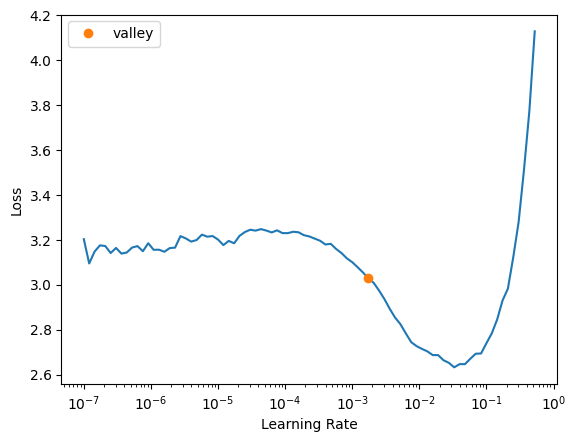

In [26]:
trainValid_Learner= vision_learner(trainValid_Dls, resnet34, loss_func=loss_func, metrics=accuracy)

# Find the optimal learning rate
learningRateResNet34 = trainValid_Learner.lr_find()

# Print the optimal learning rates found
print(f"Optiomal learning rate is {learningRateResNet34}")

epoch,train_loss,valid_loss,accuracy,time
0,2.222834,1.404563,0.391421,03:31


Better model found at epoch 0 with valid_loss value: 1.4045625925064087.


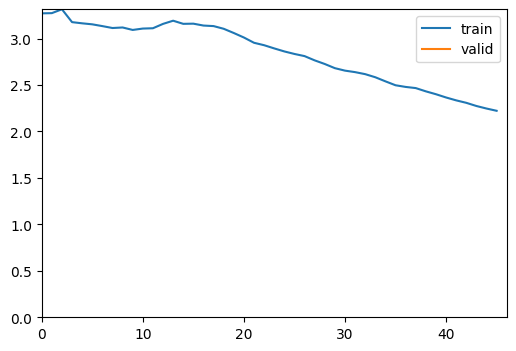

epoch,train_loss,valid_loss,accuracy,time
0,1.548141,1.081590,0.450402,04:34
1,1.291867,0.981703,0.526810,04:46
2,1.091204,0.821252,0.564343,04:41
3,0.883589,0.725344,0.613941,04:41
4,0.750471,0.699368,0.626005,04:36


Better model found at epoch 0 with valid_loss value: 1.0815895795822144.


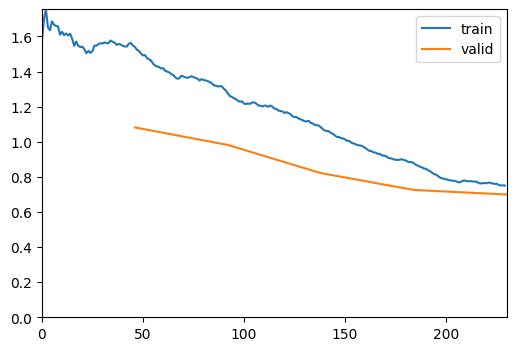

Better model found at epoch 1 with valid_loss value: 0.9817025661468506.
Better model found at epoch 2 with valid_loss value: 0.8212522268295288.
Better model found at epoch 3 with valid_loss value: 0.7253440618515015.
Better model found at epoch 4 with valid_loss value: 0.6993682384490967.


In [27]:
trainValid_Learner.fine_tune(5, 0.001737800776027143, cbs=[ShowGraphCallback(), EarlyStoppingCallback(min_delta=0.001, patience=10), SaveModelCallback()])

## Displaying the results of model

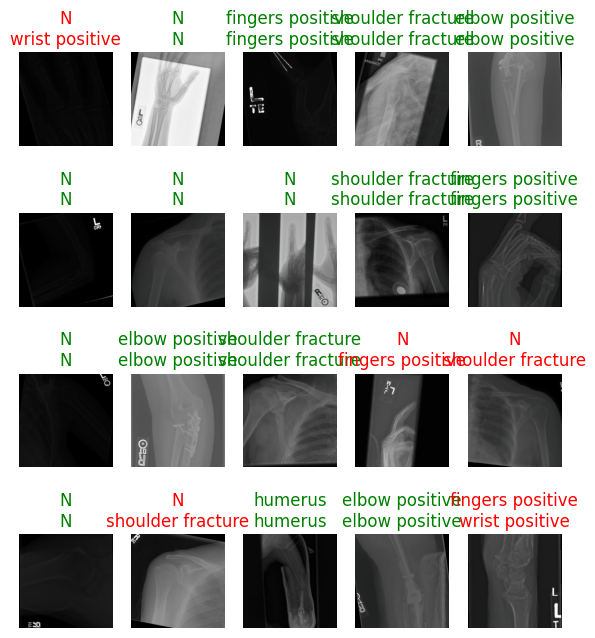

In [28]:
# visualize results (top row: true labels, bottom row: predicted labels)
trainValid_Learner.show_results(max_n = 20, figsize=(7,8))

## Testing on test set now to see if we get better accurcies

In [34]:
# Assuming test_image_files contains paths to your test images
test_dl = trainValid_Dls.test_dl(test_image_files, with_labels=True)

# Using the pretrained model to get predictions on the test DataLoader
preds, targets = trainValid_Learner.get_preds(dl=test_dl)

In [32]:
predicted_classes = preds.argmax(dim=1)

In [33]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Calculate accuracy
accuracy = accuracy_score(targets.numpy(), predicted_classes.numpy())
print(f"Accuracy on test set: {accuracy}")

# Classification report
print(classification_report(targets.numpy(), predicted_classes.numpy(), target_names=class_names))

# Confusion Matrix
print(confusion_matrix(targets.numpy(), predicted_classes.numpy()))


Accuracy on test set: 0.6763285024154589
                   precision    recall  f1-score   support

   elbow positive       0.94      0.52      0.67       206
 fingers positive       0.51      0.88      0.65        34
 forearm fracture       0.69      0.69      0.69        49
 humerus fracture       0.66      0.89      0.76        28
          humerus       0.60      0.84      0.70        38
shoulder fracture       0.62      0.90      0.74        39
   wrist positive       0.38      0.85      0.52        20

         accuracy                           0.68       414
        macro avg       0.63      0.80      0.68       414
     weighted avg       0.77      0.68      0.68       414

[[107  25  11  10  18  19  16]
 [  1  30   1   0   2   0   0]
 [  0   1  34   2   1   0  11]
 [  0   1   1  25   0   0   1]
 [  3   2   0   0  32   1   0]
 [  3   0   0   1   0  35   0]
 [  0   0   2   0   0   1  17]]


# Make Branch and test various models under here...

# Alexnet test

SuggestedLRs(valley=0.001737800776027143)

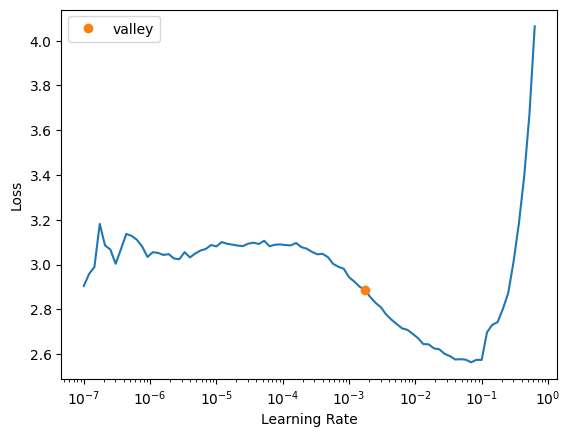

In [53]:
trainValid_alexnet = vision_learner(trainValid_Dls, alexnet, loss_func=loss_func, metrics=accuracy)

# Find the optimal learning rate using lr_find
trainValid_alexnet.lr_find()

Better model found at epoch 0 with valid_loss value: 1.175225853919983.


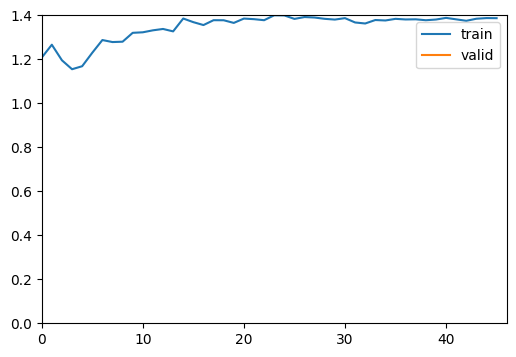

epoch,train_loss,valid_loss,accuracy,time
0,1.225695,1.059772,0.470509,01:01
1,1.134668,0.957312,0.522788,01:01
2,1.107684,0.945586,0.541555,01:01
3,1.062597,0.889176,0.572386,01:01
4,1.000660,0.872497,0.563003,01:01
5,0.937728,0.873484,0.577748,01:02
6,0.855316,0.917230,0.623324,01:01
7,0.820247,0.807880,0.640751,01:01
8,0.750781,0.749104,0.655496,01:01
9,0.714095,0.747475,0.621984,01:02


Better model found at epoch 0 with valid_loss value: 1.0597715377807617.


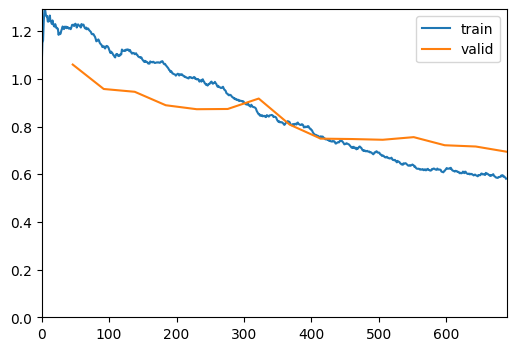

Better model found at epoch 1 with valid_loss value: 0.9573116302490234.
Better model found at epoch 2 with valid_loss value: 0.945586085319519.
Better model found at epoch 3 with valid_loss value: 0.889175534248352.
Better model found at epoch 4 with valid_loss value: 0.8724969625473022.
Better model found at epoch 7 with valid_loss value: 0.8078802227973938.
Better model found at epoch 8 with valid_loss value: 0.749103844165802.
Better model found at epoch 9 with valid_loss value: 0.7474752068519592.
Better model found at epoch 10 with valid_loss value: 0.744392454624176.
Better model found at epoch 12 with valid_loss value: 0.7214184999465942.
Better model found at epoch 13 with valid_loss value: 0.7161059379577637.
Better model found at epoch 14 with valid_loss value: 0.694180428981781.


In [55]:
trainValid_alexnet.fine_tune(15, 0.0017, cbs=[ShowGraphCallback(), EarlyStoppingCallback(min_delta=0.001, patience=10), SaveModelCallback()])

## Testing on test set now to see if we get better accurcies

In [66]:
# Assuming test_image_files contains paths to your test images
test_dl = trainValid_Dls.test_dl(test_image_files, with_labels=True)

# Using the pretrained model to get predictions on the test DataLoader
preds, targets = trainValid_alexnet.get_preds(dl=test_dl)

predicted_classes = preds.argmax(dim=1)

In [67]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Calculate accuracy
accuracy = accuracy_score(targets.numpy(), predicted_classes.numpy())
print(f"Accuracy on test set for Alexnet: {accuracy}")

# Classification report
print(classification_report(targets.numpy(), predicted_classes.numpy(), target_names=class_names))

# Confusion Matrix
print(confusion_matrix(targets.numpy(), predicted_classes.numpy()))


Accuracy on test set for Alexnet: 0.678743961352657
                   precision    recall  f1-score   support

   elbow positive       0.87      0.56      0.68       206
 fingers positive       0.64      0.88      0.74        34
 forearm fracture       0.79      0.63      0.70        49
 humerus fracture       0.50      0.68      0.58        28
          humerus       0.60      0.82      0.69        38
shoulder fracture       0.54      0.92      0.68        39
   wrist positive       0.49      0.90      0.63        20

         accuracy                           0.68       414
        macro avg       0.63      0.77      0.67       414
     weighted avg       0.74      0.68      0.68       414

[[116  11   8  15  17  29  10]
 [  2  30   0   0   2   0   0]
 [  6   2  31   2   0   0   8]
 [  6   2   0  19   0   0   1]
 [  2   2   0   1  31   2   0]
 [  2   0   0   0   1  36   0]
 [  0   0   0   1   1   0  18]]
